<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex06/patrick_ferreira/ex06_patrick_ferreira.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento de uma CNN no CIFAR 10

In [509]:
nome = "Patrick de Carvalho Tavares Rezende Ferreira"

print(f'Meu nome é {nome}')

Meu nome é Patrick de Carvalho Tavares Rezende Ferreira


Este exercicío consiste em implementar e treinar no CIFAR-10 vários blocos de uma Resnet seguido de uma camada linear de classificação.

## Importação das bibliotecas

In [510]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

## Fixando as seeds

In [511]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [512]:
batch_size = 50

## Download do CIFAR-10

In [513]:
!mkdir ./data

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)


mkdir: cannot create directory ‘./data’: File exists
Files already downloaded and verified
Files already downloaded and verified


## Criação do dataloader

In [514]:
train_size = 40000
val_size = 10000
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [515]:
batch_size = 50

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Número de minibatches de trenamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))
print('Número de minibatches de teste:', len(test_dataloader))

x_train, y_train = next(iter(train_dataloader))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 800
Número de minibatches de validação: 200
Número de minibatches de teste: 200

Dimensões dos dados de um minibatch: torch.Size([50, 3, 32, 32])
Valores mínimo e máximo dos pixels:  tensor(-1.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Implementando o Bloco Básico da Resnet

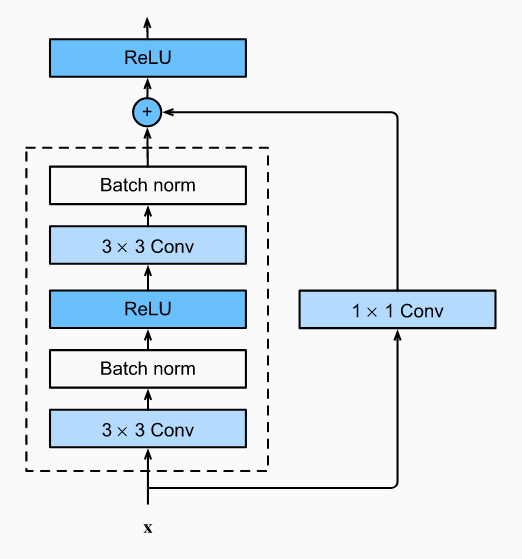

In [516]:
from torch import nn
from torch import Tensor


class MyBasicBlock(nn.Module):

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
    ) -> None:
        super().__init__()
        # Escreva seu código aqui.

        self.conv1 = nn.Conv2d(inplanes, planes, 3, stride, padding=(1,1), groups=1, bias=False, dilation=1)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(planes, planes, 3, 1, padding=(1,1), groups=1, bias=False, dilation=1)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = nn.Conv2d(inplanes, planes, 1, stride, padding=0, groups=1, bias=False, dilation=1)


    def forward(self, x: Tensor) -> Tensor:
        # Escreva seu código aqui.

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        x = self.relu(out + self.downsample(x))

        return x

## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [517]:
import torchvision

height_in = 5
width_in = 5
inplanes = 2
planes = 3
stride = 2

x = torch.rand(1, inplanes, height_in, width_in)

block = MyBasicBlock(inplanes=inplanes, planes=planes, stride=stride)

downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, groups=1, bias=False, dilation=1)

block_pt = torchvision.models.resnet.BasicBlock(inplanes=inplanes, planes=planes, stride=stride, downsample=downsample)

# Usa os mesmos pesos para minha implementação e a do pytorch
block.load_state_dict(block_pt.state_dict())

target_out = block_pt(x)
out = block(x)

print(f'out:\n{out}')
print(f'target_out:\n{target_out}')

assert torch.allclose(out, target_out, atol=1e-6)

out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)
target_out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)


## Modelo

Implemente um modelo de classificação que será treinado no CIFAR-10. O modelo deve ter dois blocos básicos da Resnet.

In [518]:
class Net(torch.nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        # Escreva seu código aqui.
        self.block1 = MyBasicBlock(inplanes=3, planes=64, stride=stride)
        self.block2 = MyBasicBlock(inplanes=64, planes=64, stride=stride)
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.linear_classifier = nn.Linear(64, 10)        

    def forward(self, x):
        # Escreva seu código aqui.

        x = self.block1(x)        
        x = self.block2(x)
        x = self.pooling(x).squeeze()
        x = self.linear_classifier(x)

        return x

## Treinamento

### Definição dos hiperparâmetros

In [519]:
n_epochs = 20
lr = 0.01

### Detectando a GPU

In [520]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [521]:
def evaluation(model, loader):
    # Escreva seu código aqui.

    total = 0
    acertos = 0
    for x, y in loader:
        y_hat = model(x.to(device))
        y_hat = torch.argmax(y_hat, dim=1) # pega somente as classes preditas

        # coloca no mesmo device para poder operar os tensores juntos
        y = y.to(device) 
        y_hat = y_hat.to(device)

        # conta numero de acertos (classe predita == classe target)
        acertos += y[y == y_hat].shape[0]
        # conta numero total de samples no batch
        total += 1 * x.shape[0]

    mean_accuracy = acertos / total
    
    print(f'Accuracy: {mean_accuracy}')

### Laço de treinamento

In [522]:
from tqdm import tqdm


model = Net()

model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0

# Primeira avaliação com pesos aleatórios
evaluation(model=model, loader=val_dataloader)

for i in range(n_epochs):
    model.train()
    for x_train, y_train in tqdm(train_dataloader, total=len(train_dataloader), desc='Training'):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(train_dataset))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')

    # Chama a função de validação no final de cada época
    evaluation(model=model, loader=val_dataloader)

Accuracy: 0.1023


Training: 100%|██████████| 800/800 [00:27<00:00, 29.57it/s]


Epoch: 0/19 Loss: 1.7030006647109985
Accuracy: 0.4087


Training: 100%|██████████| 800/800 [00:27<00:00, 29.50it/s]


Epoch: 1/19 Loss: 1.2678645849227905
Accuracy: 0.4723


Training: 100%|██████████| 800/800 [00:27<00:00, 29.52it/s]


Epoch: 2/19 Loss: 1.3896527290344238
Accuracy: 0.5192


Training: 100%|██████████| 800/800 [00:26<00:00, 29.67it/s]


Epoch: 3/19 Loss: 1.2408077716827393
Accuracy: 0.546


Training: 100%|██████████| 800/800 [00:26<00:00, 29.67it/s]


Epoch: 4/19 Loss: 1.23137629032135
Accuracy: 0.5701


Training: 100%|██████████| 800/800 [00:26<00:00, 29.72it/s]


Epoch: 5/19 Loss: 1.3894118070602417
Accuracy: 0.6015


Training: 100%|██████████| 800/800 [00:27<00:00, 29.61it/s]


Epoch: 6/19 Loss: 1.240459680557251
Accuracy: 0.6089


Training: 100%|██████████| 800/800 [00:26<00:00, 29.68it/s]


Epoch: 7/19 Loss: 1.2383352518081665
Accuracy: 0.6216


Training: 100%|██████████| 800/800 [00:26<00:00, 29.81it/s]


Epoch: 8/19 Loss: 0.9954634308815002
Accuracy: 0.6368


Training: 100%|██████████| 800/800 [00:26<00:00, 29.65it/s]


Epoch: 9/19 Loss: 0.8626152873039246
Accuracy: 0.6372


Training: 100%|██████████| 800/800 [00:27<00:00, 29.50it/s]


Epoch: 10/19 Loss: 0.8304802775382996
Accuracy: 0.6543


Training: 100%|██████████| 800/800 [00:27<00:00, 29.53it/s]


Epoch: 11/19 Loss: 0.8466101884841919
Accuracy: 0.6621


Training: 100%|██████████| 800/800 [00:26<00:00, 29.83it/s]


Epoch: 12/19 Loss: 0.8452721238136292
Accuracy: 0.6702


Training: 100%|██████████| 800/800 [00:27<00:00, 29.49it/s]


Epoch: 13/19 Loss: 0.6901068687438965
Accuracy: 0.675


Training: 100%|██████████| 800/800 [00:27<00:00, 29.57it/s]


Epoch: 14/19 Loss: 1.1091487407684326
Accuracy: 0.6713


Training: 100%|██████████| 800/800 [00:27<00:00, 29.61it/s]


Epoch: 15/19 Loss: 0.842835545539856
Accuracy: 0.6868


Training: 100%|██████████| 800/800 [00:27<00:00, 29.56it/s]


Epoch: 16/19 Loss: 0.6352871060371399
Accuracy: 0.6883


Training: 100%|██████████| 800/800 [00:26<00:00, 29.68it/s]


Epoch: 17/19 Loss: 0.7153440117835999
Accuracy: 0.6882


Training: 100%|██████████| 800/800 [00:27<00:00, 29.53it/s]


Epoch: 18/19 Loss: 0.6659109592437744
Accuracy: 0.6994


Training: 100%|██████████| 800/800 [00:26<00:00, 29.72it/s]


Epoch: 19/19 Loss: 0.6689348816871643
Accuracy: 0.7022


### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

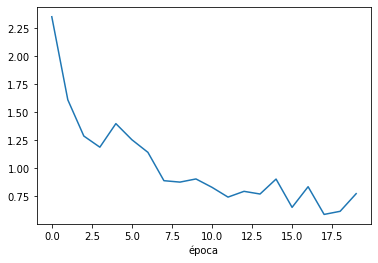

In [523]:
n_batches_train = len(train_dataloader)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

## Avaliação final no dataset de testes

In [524]:
evaluation(model=model, loader=test_dataloader)

Accuracy: 0.7045


# Bonus Opcional

## Implementando o Dropout

In [525]:
# class MyDropout(torch.nn.Module):
#     def __init__(self, p: float):
#         # Escreva seu código aqui.

#     def forward(self, x, training: bool):
#         # Escreva seu código aqui.
#         return out

## Mostre que sua implementação traz resultados semelhantes à implementação do pytorch

In [526]:
# import math

# p = 0.5
# dropout = MyDropout(p=p)

# x = torch.rand(16, 3, 32, 32)

# out = dropout(x, training=True)
# out_pt = torch.nn.functional.dropout(x, p=p, training=True)

# mean_zeros = (out == 0).sum() / out.numel()
# mean_zeros_pt = (out_pt == 0).sum() / out_pt.numel()

# print(f'mean zeros: {mean_zeros}')
# print(f'mean zeros pytorch: {mean_zeros_pt}')

# assert math.isclose(mean_zeros, mean_zeros_pt, abs_tol=1e-2)

# out = dropout(x, training=False)
# target_out = torch.nn.functional.dropout(x, p=p, training=False, inplace=False)
# assert torch.allclose(out, target_out, atol=1e-6)